# HPA -2

[HPA-2](https://www.kaggle.com/c/hpa-single-cell-image-classification/data?select=train.csv)

[HPA-1](https://www.kaggle.com/c/human-protein-atlas-image-classification/data)

## Some Useful Links
- [Previous Comp Solutions](https://github.com/CellProfiling/HPA-competition-solutions)
- [HPA Cell Segmentation](https://github.com/CellProfiling/HPA-Cell-Segmentation)
- [Bio links](https://www.kaggle.com/general/203136)
    - [Computational-biology-tutorial-1](https://www.kaggle.com/aaryamanbhattacharya/computational-biology-tutorial-1)
    - [Computational-biology-tutorial-2](https://www.kaggle.com/jasminekaur98/computational-biology-tutorial-2)
- [Some approaches](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214530)

# Defining Dataset

Per the datasheet the files needed for the comp are:
- **train** - training images (in .tif)
- **test** - test images (in .png) - the task of the competition is to segment and label the images in this folder
- **train.csv** - filenames and image level labels for the training set
- **sample_submission.csv** - filenames for the test set, and a guide to constructing a working submission.

## **Columns**

- `ID` - The base filename of the sample. As noted above all samples consist of four files - `blue`, `green`, `red`, and `yellow`.
- `Label` - in the training data, this represents the labels assigned to each sample; in submission, this represent the labels assigned to each cell.

There are 87.2k training images. I will not download all of them now. I may download a few just to test I can manipulate all the channels correctly.

(There are also TFRecord files for all the images, Tensorflows binary storage format:

"TFRecord is an individual aggregated compact file summing up all the data (present in any format) required during training/testing of a model. This particular file can be transported across multiple systems and is also independent of the model on which it is going to be trained on. The TFRecord file may also contain additional overhead data required to reconstruct the original data which may not have been needed had we trained without TFRecord. Also, in case the dataset is extremely large, we may have to create multiple similar types of TFRecord files." -  [TFRecord link](https://medium.com/ymedialabs-innovation/how-to-use-tfrecord-with-datasets-and-iterators-in-tensorflow-with-code-samples-ffee57d298af)

[Another TFRecord Link](https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564)

In [2]:
import pandas as pd

train_csv_path = '../input/train.csv'

train_csv = pd.read_csv(train_csv_path)

train_csv.head()

ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1  5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2  60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3  5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4  5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0

## Some Bio

So we have ID & Label as expected.

This dataset is a 'weak image-level' dataset. What does that mean?

Well ignoring the bio, weak image labelling is labelling at an image level. Meaning no spatial information is stored by the label but stating what is contained within the image.

For this dataset each label corresponds to a protein organelle, vesicle or negative value.

The mapping is below.


In [3]:
# Label mapping for organelles
label_map = {
    '0': 'Nucleoplasm',
    '1': 'Nuclear membrane',
    '2': 'Nucleoli',
    '3': 'Nucleoli fibrillar center',
    '4': 'Nuclear speckles',
    '5': 'Nuclear bodies',
    '6': 'Endoplasmic reticulum',
    '7': 'Golgi apparatus',
    '8': 'Intermediate filaments',
    '9': 'Actin filaments',
    '10': 'Microtubules',
    '11': 'Mitotic spindle',
    '12': 'Centrosome',
    '13': 'Plasma membrane',
    '14': 'Mitochondria',
    '15': 'Aggresome',
    '16': 'Cytosol',
    '17': 'Vesicles and punctate cytosolic patterns',
    '18': 'Negative'
}

Another important point to mention is the channels of the image.

There are 19 different labels in the dataset, 17 of which are different cells. Each cell has different morphology (morphology, in biology, the study of the size, shape, and structure). Under confocal microscopy the protein patters of different organelles may be clearer in different filters. See how confocal microscopy works below.


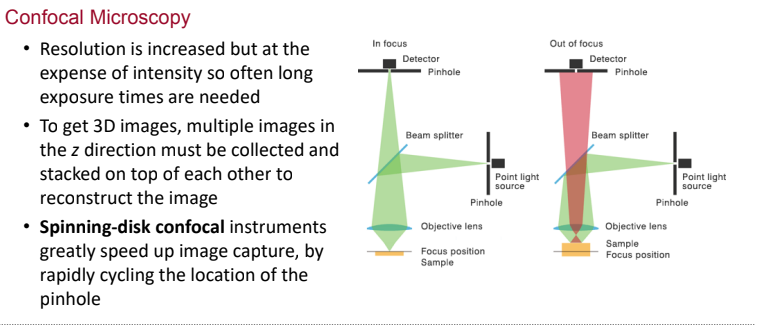


There are four filters; green, blue, red and yellow.

- `Green` Protein of interest.
- `Blue` Nucleus
- `Red` Microtubules
- `Yellow` Endoplasmic reticulum

The green filter should hence be used to predict the label, and the other filters are used as references.

Let's now look at an image and see what is going on.

In [4]:
# Sample Image ID
# 000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
i_d = '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0'
train_csv[train_csv.ID==i_d]

ID    Label
760  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7|1|2|0

So for this image we have four labels; 7,1,2,0. After looking at the mapping we can see we have:

- Golgi apparatus, 7
- Nuclear membrane, 1
- Nucleoli, 2
- Nucleoplasm, 0

## Images and Masks

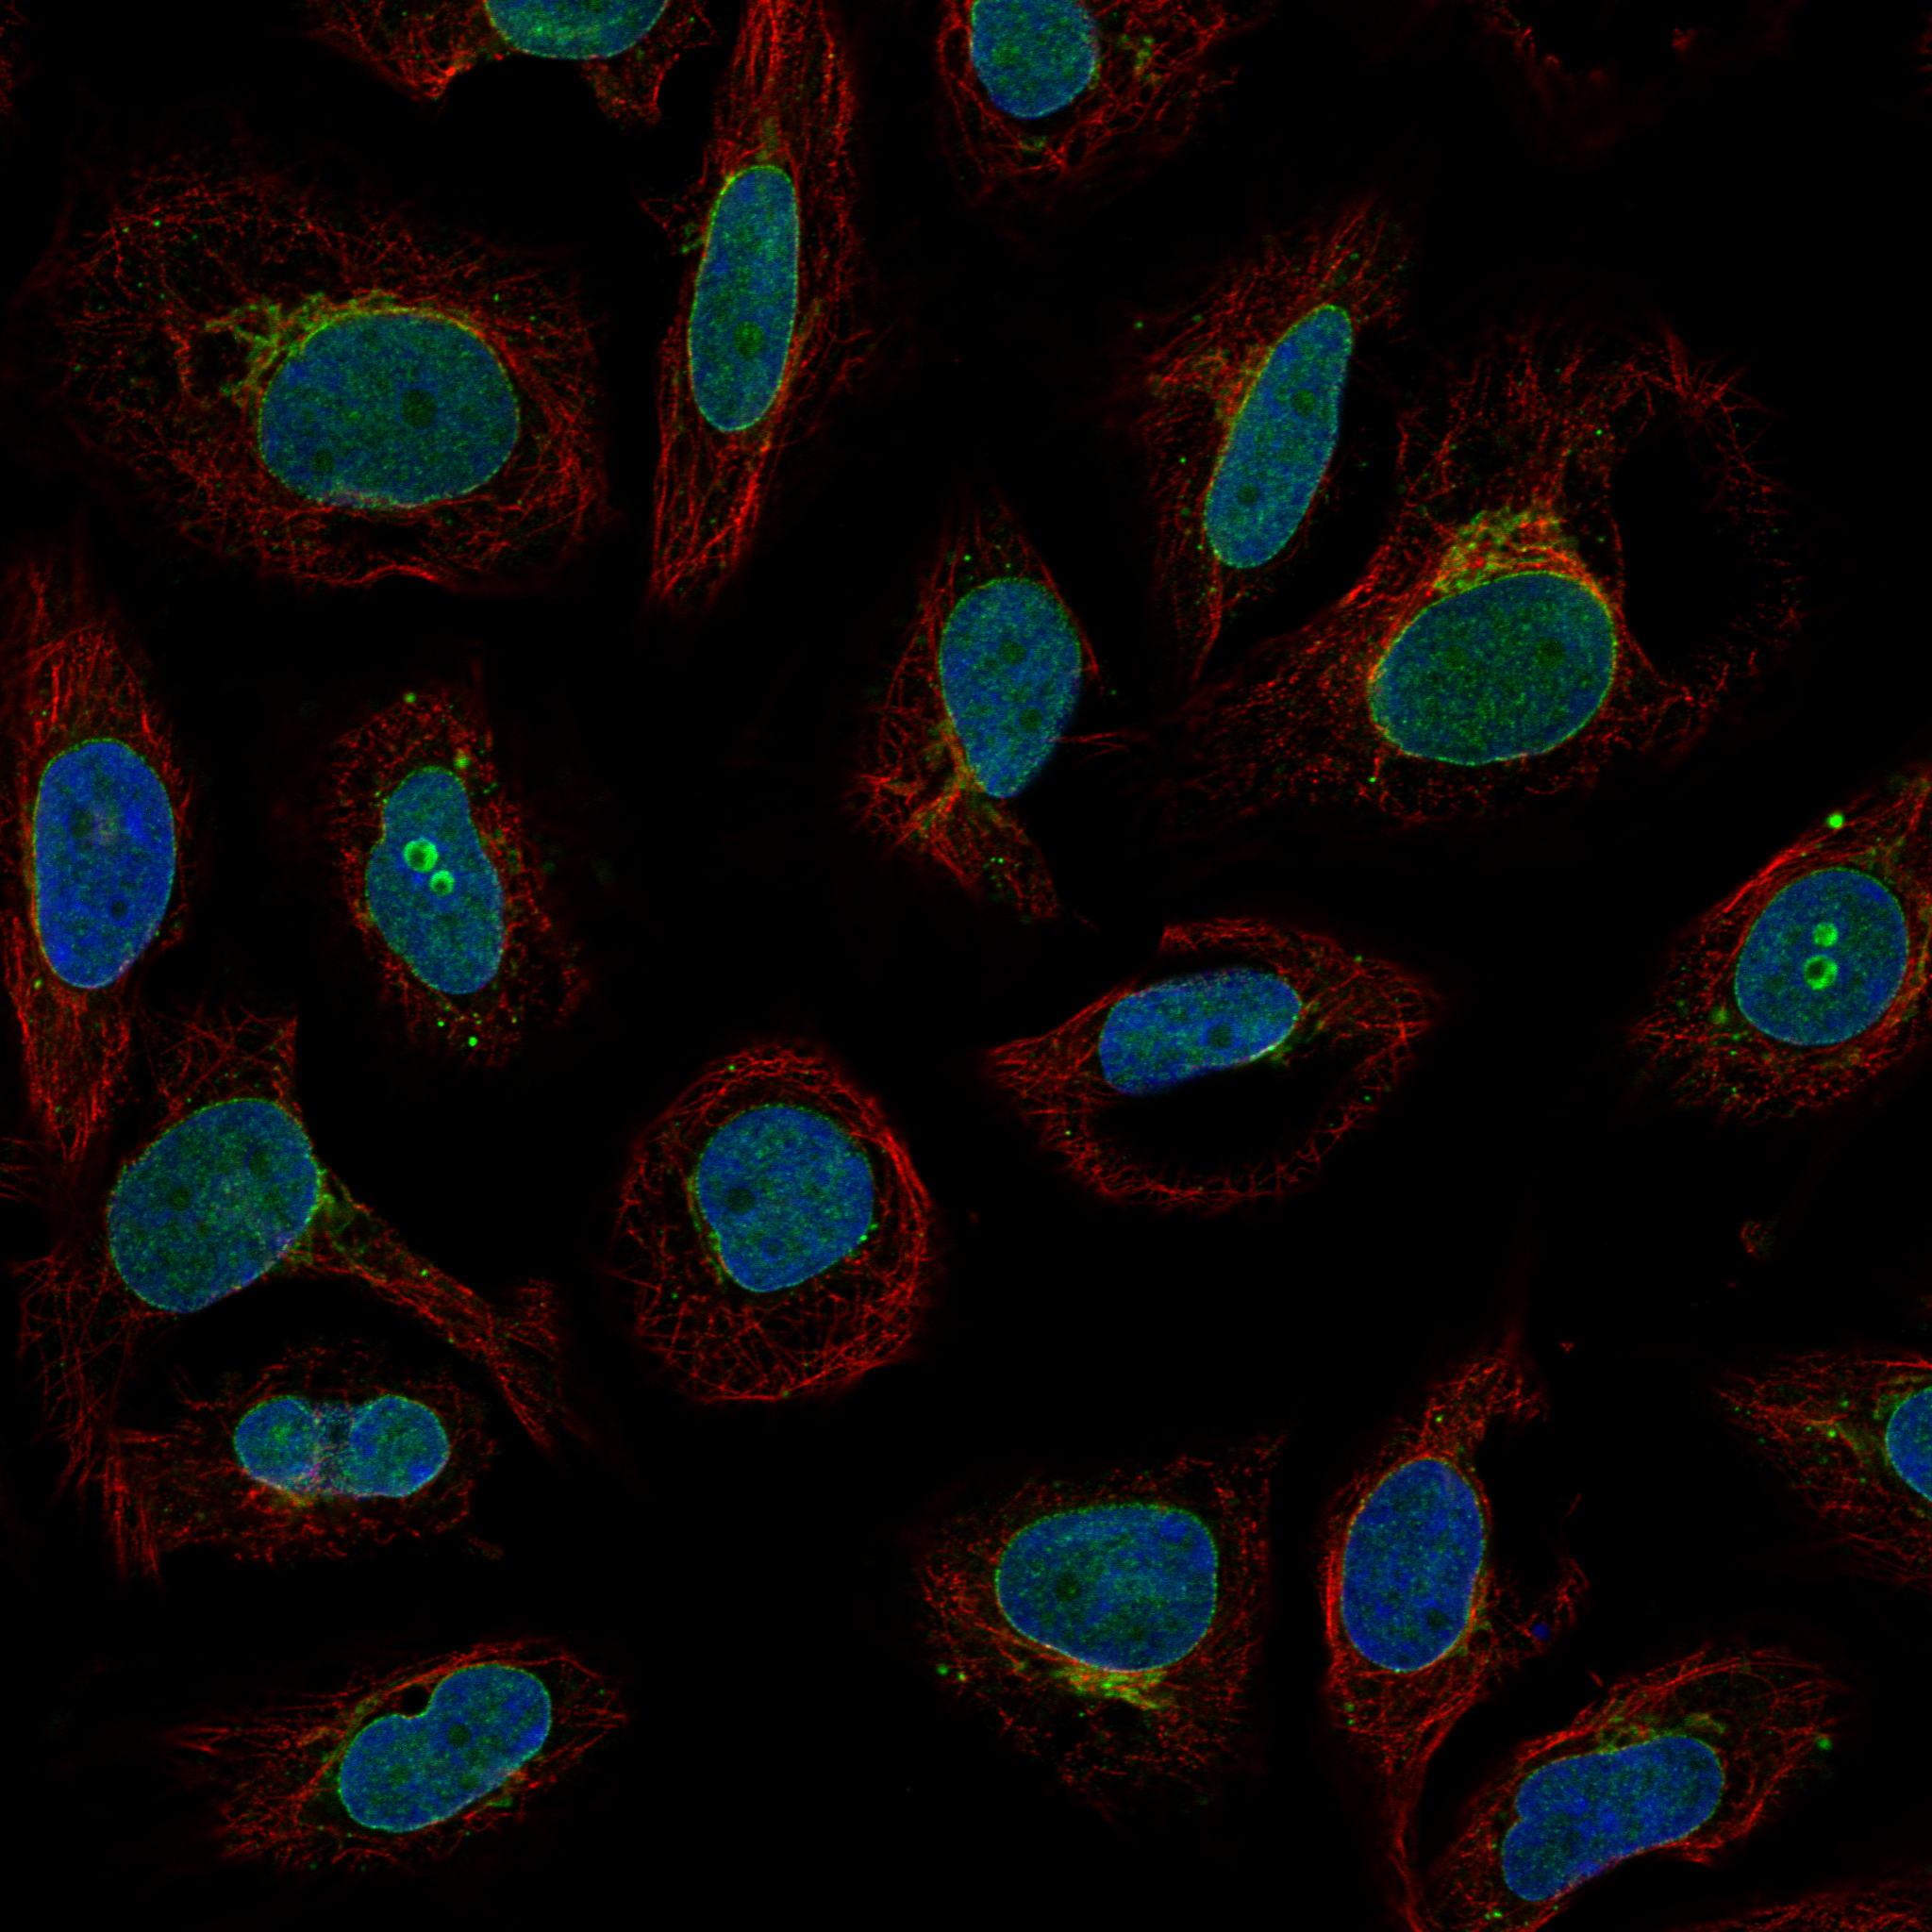

In [6]:
from PIL import Image
red    = Image.open('../input/label_examples/'+i_d+'_red.png')
green  = Image.open('../input/label_examples/'+i_d+'_green.png')
blue   = Image.open('../input/label_examples/'+i_d+'_blue.png')
yellow = Image.open('../input/label_examples/'+i_d+'_yellow.png')
rgb = Image.merge("RGB",(red,green,blue))
rgb

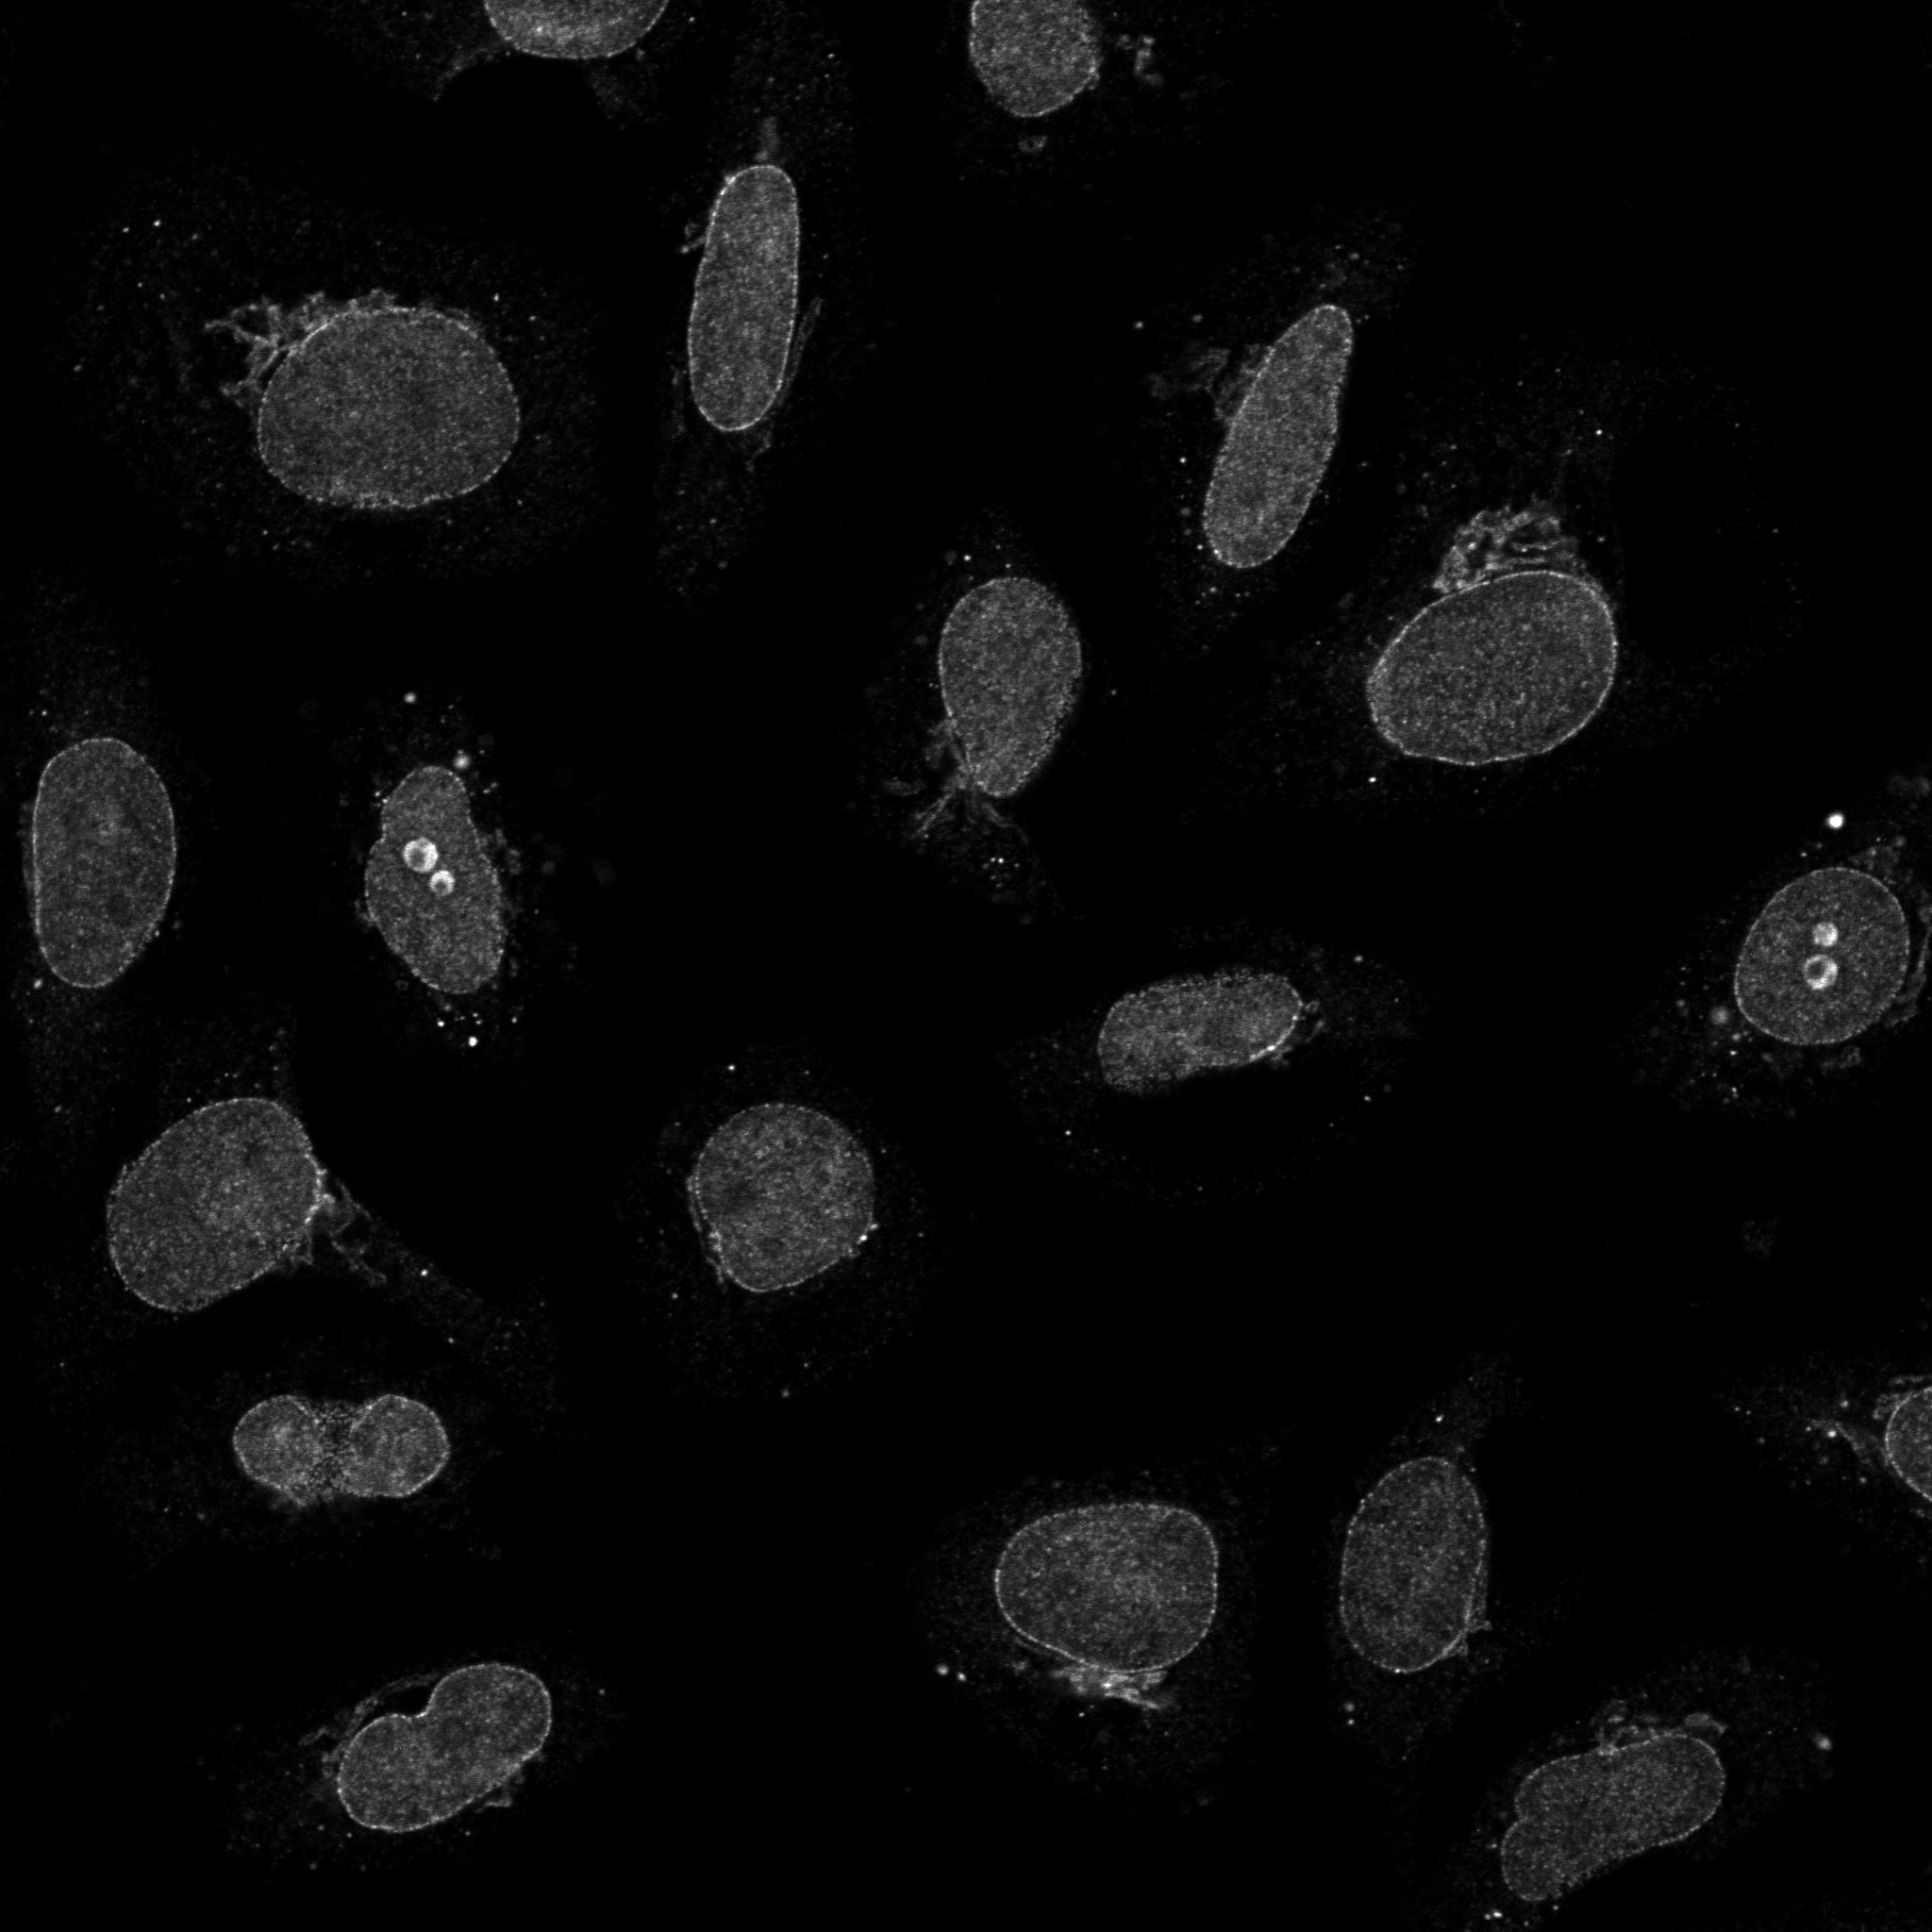

In [7]:
# Protein we are interested iN
green

In [8]:
# Image properties
image_c = [red, green, blue, yellow]

for im in image_c:
    print(im.filename, im.format, f"{im.size}x{im.mode}")

../input/label_examples/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png PNG (2048, 2048)xL
../input/label_examples/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png PNG (2048, 2048)xL
../input/label_examples/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png PNG (2048, 2048)xL
../input/label_examples/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png PNG (2048, 2048)xL


In [9]:
# Image as numpy array
import numpy as np
rgb_arr = np.array(rgb)
print('RGB numpy array: ' + str(np.shape(rgb_arr)))
green_arr = np.array(green)
print('Green numpy array: ' + str(np.shape(green_arr)))

RGB numpy array: (2048, 2048, 3)
Green numpy array: (2048, 2048)


In the datasheet there are a mix of file sizes; 1728x1728, 2048x2048 and 3072x3072 PNG files. Of course there are also the TFRecords version of the images which aren't PNG.

The datasheet states:
"During the challenge you will both need to segment the cells in the images and predict the labels of those segmented cells."

A sample submission row is shown below.

In [10]:
# Sample submission
sample_csv = pd.read_csv('../input/sample_submission.csv')
sample_csv.sample(5)

ID  ImageWidth  ImageHeight  \
376  b25d1448-86e0-4daa-b4e7-44d645825957        2048         2048   
409  bea8a86e-c5cd-4904-badd-c3b2857ce8d6        2048         2048   
540  fc66b868-6d88-4b9f-8136-acc569cac81e        2048         2048   
121  3aa2634c-fbb4-414a-b0e4-d756d8cbb9f7        2048         2048   
22   0a12663b-71ff-49e2-9fd9-b9a1bba5a9b4        2048         2048   

             PredictionString  
376  0 1 eNoLCAgIMAEABJkBdQ==  
409  0 1 eNoLCAgIMAEABJkBdQ==  
540  0 1 eNoLCAgIMAEABJkBdQ==  
121  0 1 eNoLCAgIMAEABJkBdQ==  
22   0 1 eNoLCAgIMAEABJkBdQ==

From the Evaluation Sheet

"" For each image in the test set, you must predict a list of instance segmentation masks and their associated detection score (Confidence). The submission csv file uses the following format:

`ImageID,ImageWidth,ImageHeight,PredictionString
ImageAID,ImageAWidth,ImageAHeight,LabelA1 ConfidenceA1 EncodedMaskA1 LabelA2 ConfidenceA2 EncodedMaskA2 ...
ImageBID,ImageBWidth,ImageBHeight,LabelB1 ConfidenceB1 EncodedMaskB1 LabelB2 ConfidenceB2 EncodedMaskB2 …`

Note that a mask MAY have more than one class. If that is the case, predict separate detections for each class using the same mask.

The binary segmentation masks are run-length encoded (RLE), zlib compressed, and base64 encoded to be used in text format as EncodedMask. Specifically, we use the Coco masks RLE encoding/decoding (see the encode method of COCO’s mask API), the zlib compression/decompression (RFC1950), and vanilla base64 encoding. ""

The code for this is below...

In [11]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
           "encode_binary_mask expects a binary mask, received dtype == %s" %
           mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
           "encode_binary_mask expects a 2d mask, received shape == %s" %
           mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

ModuleNotFoundError: No module named 'pycocotools'

Apparently installing pycocotools in windows is a real shit-show.

So I am just going to explore masks without the use of pycocotools. I am going to dive into masks because I think the data structure of masks is important for out task.

Some fun exmamples of image segmentation:
- [Candy](https://thecleverprogrammer.com/2020/09/01/image-segmentation-with-python/)
- [Bio Example](https://www.kite.com/blog/python/image-segmentation-tutorial/)


We have a couple keywords here to investigate; binary mask, RLE, zlib compressed, EncodedMask, COCO and base64.

Let's start with the basics, what is a mask? (Segmenting accurately is the difficult part)

A mask is essentially just an image overlayed on an image. The image on the forefront defines what you can see behind it. So a binary mask is an array of ones and zeros. The value one represents where something is and zero indicates background.

In [12]:
# https://aphdinpython.wordpress.com/2014/09/16/creating-binary-masks/
# Creating binary mask
import numpy as np
from PIL import Image

mask_arr = np.zeros((2048, 2048))

# Define centre and lengths (simple geometry really)
center = (1024,1024)
x_length = 1024
y_length = 1024

l_c = (1024-512, 1024-512)

for i in range(l_c[0], x_length):
    for j in range(l_c[1], y_length):
        mask_arr[i, j] = 1.0

print('Shape of rectangle numpy array: ' + str(np.shape(mask_arr)))
print('Max of rectangle numpy array: ' + str(mask_arr.max()))
print('Min of rectangle numpy array: ' + str(mask_arr.min()))
mask_im = Image.fromarray(255*mask_arr.astype(np.uint8));

Shape of rectangle numpy array: (2048, 2048)
Max of rectangle numpy array: 1.0
Min of rectangle numpy array: 0.0


So now we have a binary mask of a rectangle shown below..

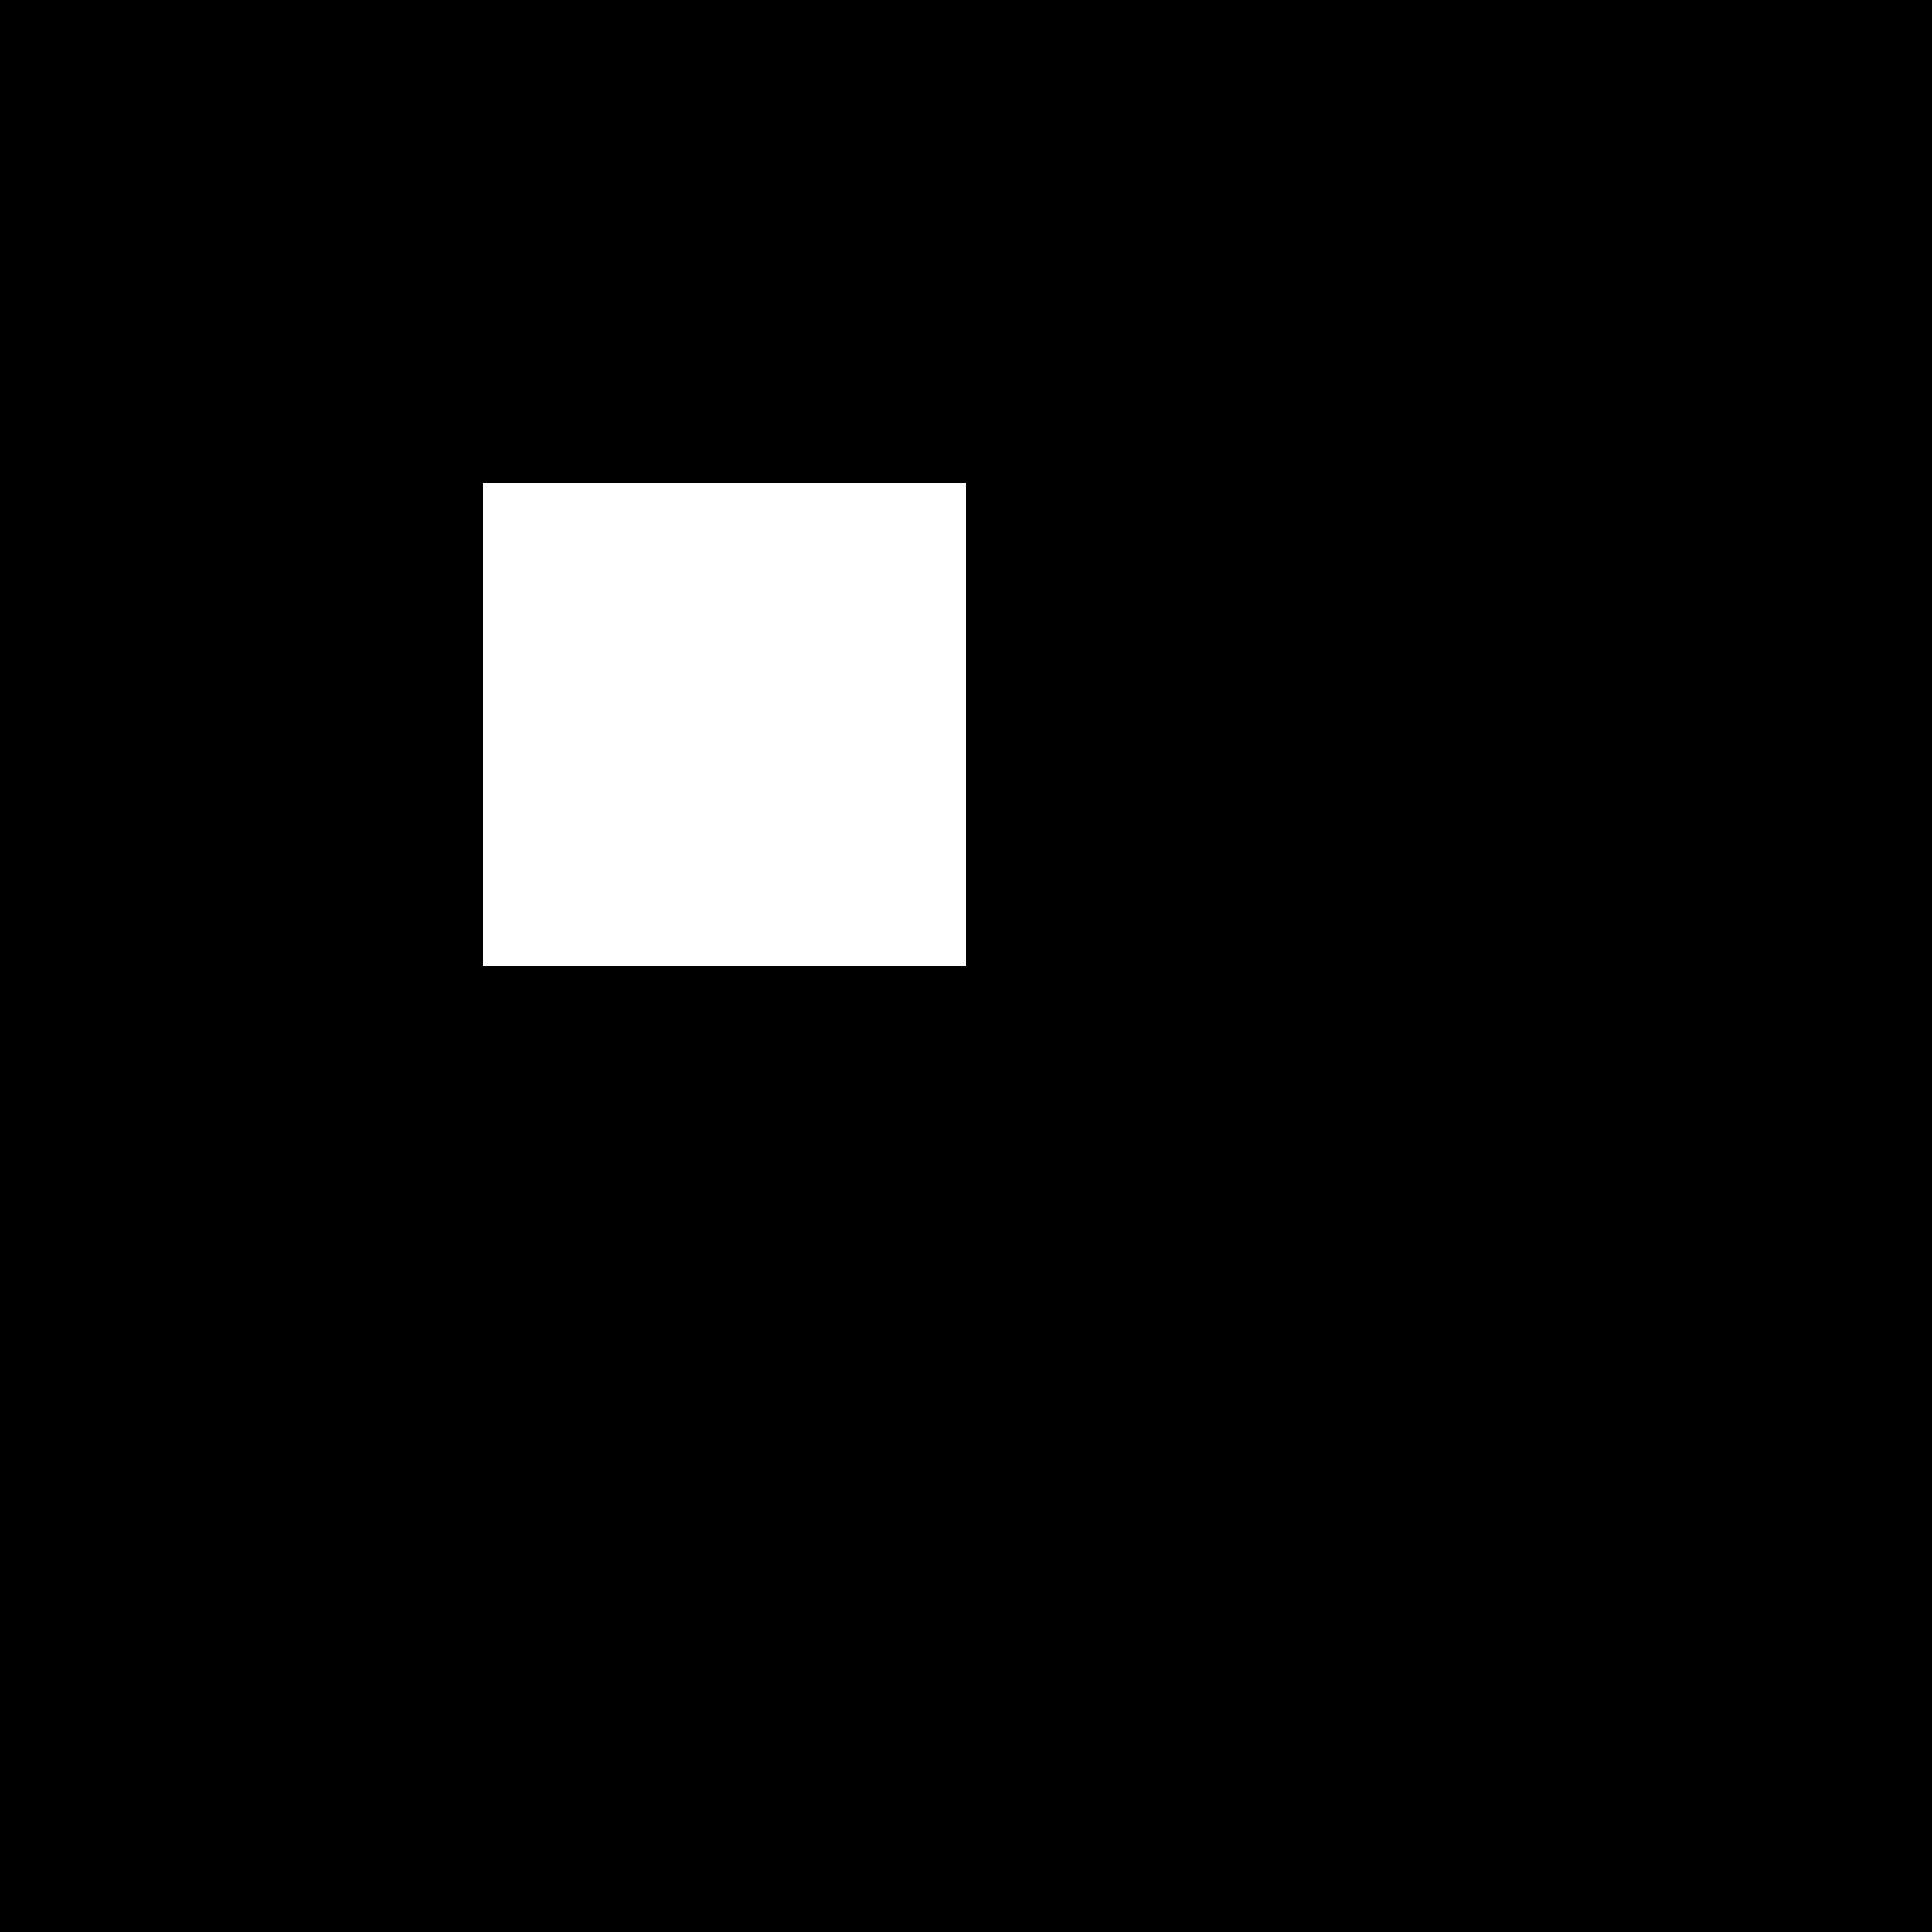

But now let's use this binary mask to mask the green channel of the image from earlier.

In [13]:
#green_arr.shape (2048, 2048)
#mask_arr.shape (2048, 2048)
masked_arr = np.where(mask_arr==1, green_arr, mask_arr)
masked_im = Image.fromarray(255*masked_arr.astype(np.uint8));

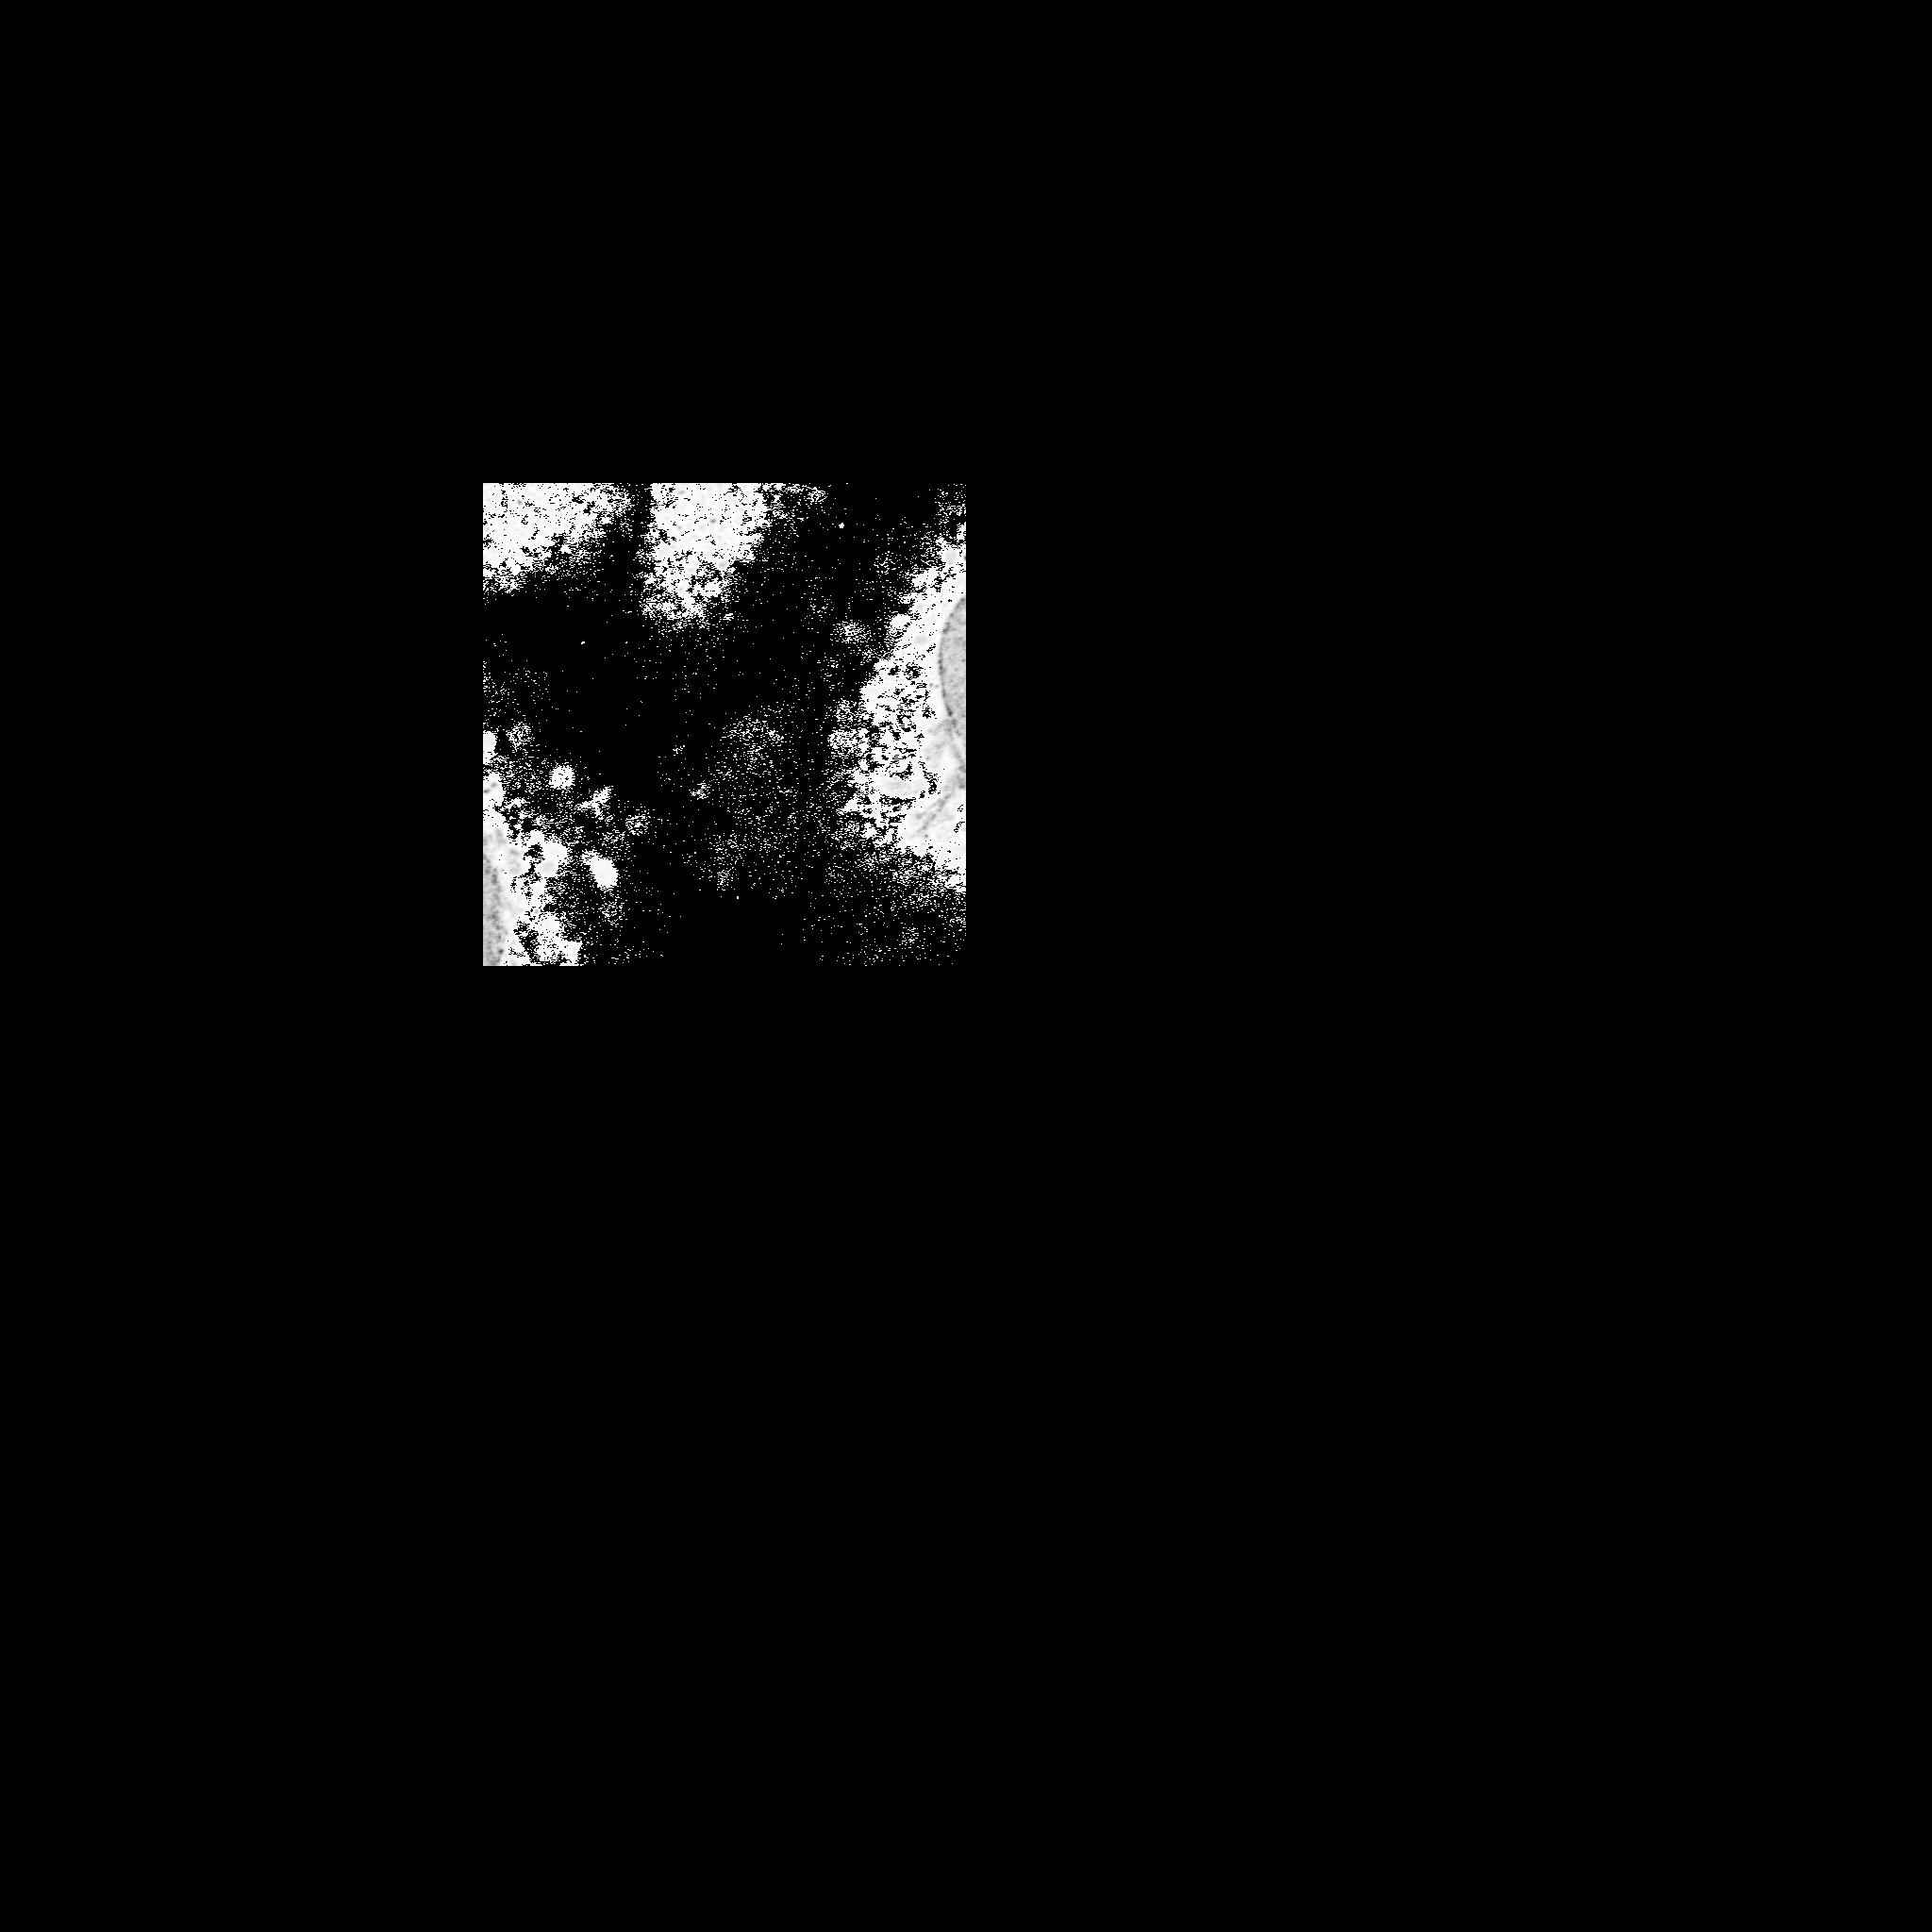

So now we have a masked array we can work out what the rest submission requires.

### RLE
[Run-length encoding](https://en.wikipedia.org/wiki/Run-length_encoding)
"Run-length encoding (RLE) is a form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run."

I think the example on the wiki is great so have a look. 

## zlib compressed
[zlib](https://docs.python.org/3/library/zlib.html)
This is just a compression library, there is no real need to dive into it, the link is above if you really want to.
 
## base64
[base64](https://en.wikipedia.org/wiki/Base64)
This is just a binary-to-text encoding scheme. It is what gives the "predicted string" its string part!

## COCO
[COCO](https://cocodataset.org/#download)
The coco part of this is just using the RLE encoder function. So we will have to either write our own or find another package that will do just that (I'm thinking the latter).

In [14]:
import base64
import numpy as np
import typing as t
import zlib

# Need to work this one out...

class RLE:
    # Encode RLE
    def encode(data):
        pass
    # Decode RLE
    def decode(data):
        pass
        
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""
    
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
    mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    rle=RLE()
    encoded_mask = rle.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    
    return(base64_str)

## To do
- Try out HPA-Cell-Segmentation on some examples
- Work out how to encode RLE without coco mask api
- Start looking at some models